In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


# Titanic Dataset

#### Overview
Predicting who survived and who didn't using data machine learning algorithms.

#### Parts
-  Collecting the data
-  Exploratory Data Analysis
-  Feature Engineering
-  Modelling
-  Testing

Sources:

Kaggle - Titanic Solution - data analysis (3 part series)

https://www.youtube.com/watch?v=3eTSVGY_fIE

https://www.youtube.com/watch?v=COUWKVf6zKY

https://www.youtube.com/watch?v=GXWBzcAzjoQ

How to do the Titanic Kaggle competition in R (2 part series)

https://www.youtube.com/watch?v=Zx2TguRHrJE&t

https://www.youtube.com/watch?v=qpihk7KepDI




In [8]:
from IPython.display import Image
Image(url="https://upload.wikimedia.org/wikipedia/commons/5/51/Titanic_voyage_map.png")

## 1. Collecting Data

### 1a. Importing Data

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load datasets 
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [10]:
print("Shape of training data: {}".format(train.shape))
print("Shape of test data: {}".format(test.shape))

Shape of training data: (891, 12)
Shape of test data: (418, 11)


The test data does not contain a column for **Survived**.

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1b. Combining Test and Training Data

Combining the test and training data will expedite the preprocessing, analysis and feature engineering steps. Additionally the test variables need to correspond to the training variables. 

In [13]:
# Create a list of the train and test datasets for iteration
train_test = [train, test]

# Combine the train and test datasets into one dataframe for verification
df_train_test = pd.concat(train_test, sort=True)
print("Shape of combined data: {}".format(df_train_test.shape))

Shape of combined data: (1309, 12)


### 1c. Overview

A high-level view of the dataset to understand the number of features, types of data present, number of missing values and overall size. This uses the combined training and test dataset.

In [14]:
df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


List of Features:

-  **PassengerID*** – Index of passengers (not included in analysis)
-  **Survived*** – 0 (did not survive) or 1 (did survive)
-  **Pclass** – 1, 2, or 3 for passenger class
-  **Name** – Name of individual including title
-  **Sex** – male or female
-  **Age** – Age of individual
-  **Sibsp** – # of siblings
-  **Parch** – # of parents or children
-  **Ticket** – Ticket number (not included in analysis)
-  **Fare** – Price paid for fare
-  **Cabin** – Cabin or room #
-  **Embarked** – S (Southampton), Q (Queenstown), or C (Cherbourg)



Note*: The **Survived** column is the variable we are trying to predict. The **PassengerID** variable is simply an index and is saved for the final submission of the predicted values.

### 1d. Missing Values

This counts the null values within the entire dataset.

In [15]:
df_train_test.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
SibSp             0
Sex               0
Pclass            0
PassengerId       0
Parch             0
Name              0
dtype: int64

Four features (excluding the **Survived** variable in the test set which we are trying to predict) contain null values in the *train* dataset:
-  **Age** - 263 missing values
-  **Cabin** - 1014 missing values
-  **Embarked** - 2 missing values
-  **Fare** - 1 missing value

#### Replacing Null values

**Age** – The missing ages will be replaced with the median age of the passengers aboard.

In [16]:
for dataset in train_test:
    dataset.Age.fillna(dataset.Age.median(), inplace=True)
    df_train_test = pd.concat(train_test, sort=True)

# Check missing values of Age
df_train_test.isnull().sum()

Age               0
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

**Cabin** – The cabin data contains information about the deck location and corresponds to class. In order to decide the best way to handle the missing values a chart is made to show the distribution of classes across each deck.

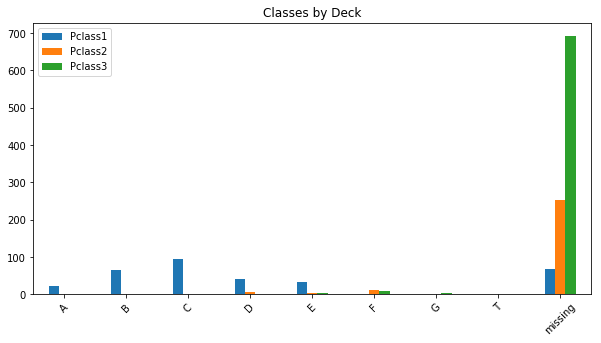

In [17]:
# Create a dataframe from the features of interest: df_cabin_deck
df_cabin_deck = pd.DataFrame({'Pclass':df_train_test.Pclass, 'Cabin':df_train_test.Cabin, 'Deck':df_train_test.Cabin.str[0]}).fillna('missing')
df_cabin_deck[['Pclass', 'Deck']]

# Subset and count number of decks for each class
Pclass3 = df_cabin_deck[df_cabin_deck.Pclass == 3]['Deck'].value_counts()
Pclass2 = df_cabin_deck[df_cabin_deck.Pclass == 2]['Deck'].value_counts()
Pclass1 = df_cabin_deck[df_cabin_deck.Pclass == 1]['Deck'].value_counts()

# Create dataframe and plot
df_decks = pd.DataFrame([Pclass1, Pclass2, Pclass3]).T.sort_index()
df_decks.columns = ['Pclass1', 'Pclass2', 'Pclass3']
df_decks.plot(kind='bar', title='Classes by Deck', figsize=(10,5))
plt.xticks(rotation=45)
plt.show()

It makes more sense to use the cabin numbers will be used to create a new feature, "**Cabin_Deck**" by extracting the deck information. Missing values will be replaced with "U" for "unknown". The **Cabin** variable is dropped because it is no longer useful.

In [18]:
# Iterate through the training and test datasets
for dataset in train_test:
   
    # Run conditionally to avoid errors
    if 'Cabin' in dataset.columns:
   
        # Extract the first letter corresponding to the deck and fill missing values with U
        dataset['Cabin_Deck'] = dataset['Cabin'].str[0].fillna('U')
   
        # Drop the Cabin column from the dataset
        dataset.drop('Cabin', axis=1, inplace=True)
        
        # re-concatenate combined dataframe
        df_train_test = pd.concat(train_test, sort=True)


# Check missing values of Cabin_Deck
print(df_train_test.isnull().sum())

df_train_test.head()

Age              0
Cabin_Deck       0
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64


,Age,Cabin_Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


**Embarked** – The data for the point of departure has two missing values across the training and test data. The feature will be graphed to visualize it's distribution. This shows the two rows with missing entries in the **Embarked** column.

In [19]:
# Display missing values for Embarked feature
train.loc[train.Embarked.isnull() == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Deck
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,B


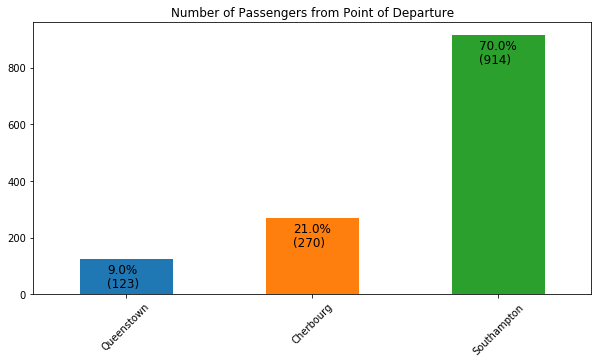

Number of passengers from each point of departure: 
Queenstown     123
Cherbourg      270
Southampton    914
Name: Embarked, dtype: int64


In [20]:
# Construction of bar plot of Embarked
df_embarked = df_train_test.Embarked.value_counts().sort_values()
df_embarked.index = ['Queenstown', 'Cherbourg', 'Southampton']

ax_embarked = df_embarked.plot(kind='bar', figsize=(10,5), title="Number of Passengers from Point of Departure")
plt.xticks(rotation=45)

# Annotating the axes with the percentage and number of passengers in each category
totals = []

for i in ax_embarked.patches:
    totals.append(i.get_height())

total_rect = sum(totals)

for i, idx in zip(ax_embarked.patches, range(3)):
    perc = round(i.get_height()/total_rect,2)*100
    perc_str = str(perc)+"%"
    x = i.get_x()+((i.get_width()/2)-0.1)
    y = i.get_height()-50
    ax_embarked.text(x, y, s=perc_str, fontsize=12)
    ax_embarked.text(x, y-50, "({})".format(df_embarked.values[idx]), fontsize=12)
    
# show plot
plt.show()
print("Number of passengers from each point of departure: ")
print(df_embarked)

Because the Southampton origin makes up about 70% of the people aboard, the 2 missing values will be filled with "S".

In [21]:
# Fill missing values of Embarked with 'S'
for dataset in train_test:
    dataset['Embarked'].fillna('S', inplace=True)
    
    # re-concatenate combined dataframe
    df_train_test = pd.concat(train_test, sort=True)
    
# Check missing values of Embarked
df_train_test.isnull().sum()

Age              0
Cabin_Deck       0
Embarked         0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

**Fare** – The missing value in the **Fare** variable will be filled with the median value for Third Class.

In [22]:
df_train_test[df_train_test.Fare.isnull() == 1]

,Age,Cabin_Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,U,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [23]:
median = df_train_test[df_train_test.Pclass == 3]['Fare'].median()
print(median)

8.05


In [24]:
for dataset in train_test:
    dataset['Fare'].fillna(median, inplace=True)
    
    # re-concatenate combined dataframe
    df_train_test = pd.concat(train_test, sort=True)
    
# Check missing values of Fare
df_train_test.isnull().sum()

Age              0
Cabin_Deck       0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

This completes the missing values. Note that the missing values in **Survived** are because the test set does not contain this data because it will be predicted as the target variable.

## 2. Exploratory Data Analysis & Feature Engineering

### Survived – Overview of Survival aboard the Titanic

Because this is our variable to be predicted, we want to see the relationships between the rate of survival and other variables. This means re-engineering some of the variables to extract more useful information, and combining others.

This plot uses the training data because the **Survived** feature is missing in the test data:

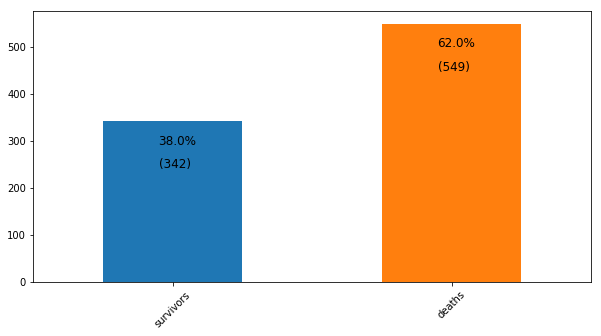

Survivors & Deaths:
survivors    342
deaths       549
Name: Survived, dtype: int64


In [25]:
# create plot of survivors
survivors = train.Survived.value_counts().sort_values()
survivors.index = ['survivors', 'deaths']
ax_survival = survivors.plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45)

# Annotate bar plot
totals = []

for i in ax_survival.patches:
    totals.append(i.get_height())

total_rect = sum(totals)

for i, idx in zip(ax_survival.patches, range(3)):
    perc = round(i.get_height()/total_rect,2)*100
    perc_str = str(perc)+"%"
    x = i.get_x()+(i.get_width()/2)-0.05
    y = i.get_height()-50
    ax_survival.text(x, y, perc_str, fontsize=12)
    ax_survival.text(x, y-50, "({})".format(str(survivors.values[idx])), fontsize=12)
    
    
plt.show()

print("Survivors & Deaths:")
print(survivors)

#### Relationships between Survival and other variables

The next step is to examine the relationship between survival and the following variables:
-  **Pclass**
-  **Name** (specifically title)
-  **Sex**
-  **Age**
-  **SibSp** & **Parch** (combined to give family size)
-  **Fare**
-  **Embarked**

Since several variables are being grouped and graphed in the same manner, it makes sense to create a function:

In [26]:
def survival_bar_chart(feature, title, legend=None):
    global survivors_feature
    global deaths_feature
    global ax_feature
    survivors_feature = train[train.Survived == 1][feature].value_counts().sort_index()
    deaths_feature = train[train.Survived == 0][feature].value_counts().sort_index()
    df = pd.DataFrame({'survivors':survivors_feature, 'deaths':deaths_feature})
    ax_feature = df.T.plot(kind='bar', figsize=(10,5), title=title)
   
    if legend != None:
        ax_feature.legend(legend)
        survivors_feature.index = legend
        deaths_feature.index = legend
        
    plt.xticks(rotation=45)    
    plt.show()

### Pclass – Survival by Passenger class
**Pclass**, or passenger class is a rough proxy for socioeconomic status. Before comparing the relationship with **Survived**, it's useful to understand the behavior of this feature by looking at some graphs and statistics.

**Pclass** is actually a categorical variable with integers 1-3 corresponding to First, Second and Third classes aboard the titanic. This is important to consider in our treatment of the variable.

In [27]:
df_train_test[['Survived', 'Pclass']].head(10)

,Survived,Pclass
0,0.0,3
1,1.0,1
2,1.0,3
3,1.0,1
4,0.0,3
5,0.0,3
6,0.0,1
7,0.0,3
8,1.0,3
9,1.0,2


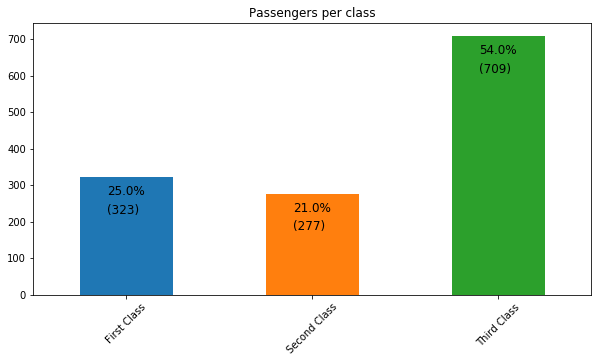

First Class     323
Second Class    277
Third Class     709
Name: Pclass, dtype: int64


In [28]:
# Calculate number of entries (passengers) in each class 1-3
df_pclass = df_train_test.Pclass.value_counts().sort_index()
df_pclass.index = ['First Class', 'Second Class', 'Third Class']

# Create plot of passengers per class
ax_pclass = df_pclass.plot(kind='bar', figsize=(10,5), title='Passengers per class')
plt.xticks(rotation=45)

totals = []

for i in ax_pclass.patches:
    totals.append(i.get_height())

total_rect = sum(totals)

for i, idx in zip(ax_pclass.patches, range(3)):
    perc = round(i.get_height()/total_rect,2)*100
    perc_str = str(perc)+"%"
    x = i.get_x()+(i.get_width()/2)-0.1
    y = i.get_height()-50
    ax_pclass.text(x, y, perc_str, fontsize=12)
    ax_pclass.text(x, y-50, "({})".format(str(df_pclass.values[idx])), fontsize=12)
    
plt.show()

print(df_pclass)

This looks at who survived by passenger class, using the variable **Pclass**. We can see from the bar chart that the highest number of deaths were of 3rd class passengers. This brings up a question to explore, why did so many 3rd class passengers not survive? The answer probably has something to do with the location of the 3rd class cabins when the ship was sinking. 

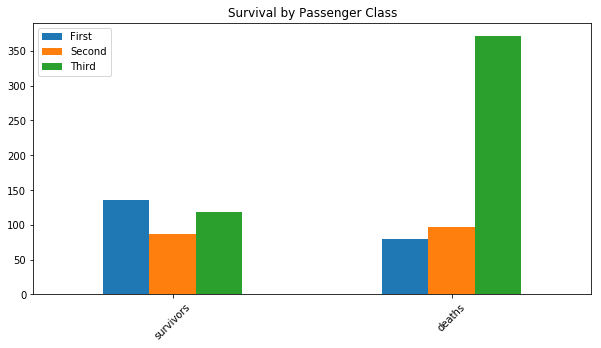

Survivors by Passenger class: 
First     136
Second     87
Third     119
Name: Pclass, dtype: int64
Deaths by Passenger class: 
First      80
Second     97
Third     372
Name: Pclass, dtype: int64


In [29]:
survival_bar_chart('Pclass', 'Survival by Passenger Class', ['First', 'Second', 'Third'])
print("Survivors by Passenger class: ")
print(survivors_feature)
print("Deaths by Passenger class: ")
print(deaths_feature)

The class with the highest number of survivors was First Class, and the highest amount of deaths was Third Class. The class with the lowest number of survivors was Second Class.

**Percentage of survivors by passenger class:**

In [30]:
print("Ratio of survival by Passenger class: ")
print(survivors_feature / (survivors_feature + deaths_feature))

Ratio of survival by Passenger class: 
First     0.629630
Second    0.472826
Third     0.242363
Name: Pclass, dtype: float64


-  62% of First Class passengers survived
-  47% of Second Class passengers survived
-  24% of Third Class passengers survived

### Name
This looks at the relationship between the title of the passenger (Mr., Mrs., Dr., etc.) and who survived. In order to examine we need to count the appearances of different titles within the **Name** variable and create a new column.

In [31]:
df_train_test[['Survived', 'Name']].head()

,Survived,Name
0,0.0,"Braund, Mr. Owen Harris"
1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,1.0,"Heikkinen, Miss. Laina"
3,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,0.0,"Allen, Mr. William Henry"


In [32]:
# Extract titles from name and create new dataframe: df_titles
title_str = ' ([A-Za-z]+)\.'

for dataset in train_test:
    df_titles = dataset.Name.str.extract(title_str)
    df_titles.columns = ['Title'] 
    dataset['Title'] = df_titles
   
    # re-concatenate combined dataframe
    df_train_test = pd.concat(train_test, sort=True)

**Unique Titles**

Overview of the different titles of passengers aboard Titanic:

In [33]:
df_train_test.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Major         2
Mlle          2
Mme           1
Dona          1
Countess      1
Jonkheer      1
Don           1
Sir           1
Lady          1
Capt          1
Name: Title, dtype: int64

By examining the number of unique titles we can see general categories of male & female and professional and non-professional and nobility. We will use these to categorize the data and reduce the number of dimensions of this feature by creating a new column 'Title' and assigning an integer 0-5 for each group of titles:

-  No title (**0**)
-  *Mr., Master*: Male Non-professional (**1**)
-  *Miss, Mrs., Ms., Mlle, Mme*: Female Non-professional (**2**)
-  *Dr, Rev., Major., Col., Capt.*: Professional (**3**)
-  *Don, Dona, Countess, Lady, Jonkheer, Sir*: Nobility (**4**)

Because the we have extracted all the information we want from the **Name** field it will be removed and **PassengerId** will be used to identify individuals.

In [34]:
# create dict to map titles to integers 1-4: title_dict
title_dict = {'Mr':1, 'Master':1, 'Miss':2, 'Mrs':2, 'Ms':2, 'Mlle':2, 'Mme':2,
             'Dr':3, 'Rev':3, 'Major':3, 'Col':3, 'Capt':3, 'Don':4, 'Dona':4, 'Countess':4, 
             'Lady':4, 'Jonkheer':4, 'Sir':4}

for dataset in train_test:
      if 'Name' in dataset.columns:

        # Apply title_dict mapping to data
        dataset['Title_group'] = dataset.Title.map(title_dict)
    
        # Drop the Name column from the dataset
        # dataset.drop('Name', axis=1, inplace=True)
    
        # re-concatenate combined dataframe
        df_train_test = pd.concat(train_test, sort=True)


df_train_test.tail(10)

,Age,Cabin_Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Title_group
408,27.0,U,Q,7.7208,"Riordan, Miss. Johanna Hannah""""",0,1300,3,female,0,NaN,334915,Miss,2
409,3.0,U,S,13.7750,"Peacock, Miss. Treasteall",1,1301,3,female,1,NaN,SOTON/O.Q. 3101315,Miss,2
410,27.0,U,Q,7.7500,"Naughton, Miss. Hannah",0,1302,3,female,0,NaN,365237,Miss,2
411,37.0,C,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928,Mrs,2
412,28.0,U,S,7.7750,"Henriksson, Miss. Jenny Lovisa",0,1304,3,female,0,NaN,347086,Miss,2
413,27.0,U,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Mr,1
414,39.0,C,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,Dona,4
415,38.5,U,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,Mr,1
416,27.0,U,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr,1
417,27.0,U,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,Master,1


In [35]:
df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1309 non-null float64
Cabin_Deck     1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Title_group    1309 non-null int64
dtypes: float64(3), int64(5), object(6)
memory usage: 153.4+ KB


We see that the new feature **Title_group** contains the same number of entries as the complete dataframe. This means that every passenger has a title including children. The next step is to adjust for age and separate the children from the adults, so that the titles apply only to the adult passengers, and replace the values of passengers under age 14 with '0'. The age 14 was chosen because at least one woman of 14 years has the title "Mrs".

In [36]:
for dataset in train_test:
    dataset['Title_group'] = np.where(dataset.Age < 14, 0, dataset.Title_group)
    
    # re-concatenate combined dataframe
    df_train_test = pd.concat(train_test, sort=True)

#df_train_test[['Age', 'Title', 'Title_group']].head(20)

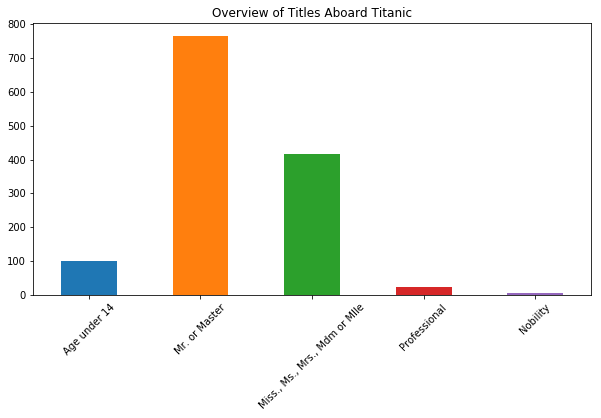

Age under 14                      99
Mr. or Master                    765
Miss., Ms., Mrs., Mdm or Mlle    416
Professional                      23
Nobility                           6
Name: Title_group, dtype: int64

In [37]:
title_groups = df_train_test.Title_group.value_counts().sort_index()
title_groups

title_groups.index = ['Age under 14', 'Mr. or Master', 'Miss., Ms., Mrs., Mdm or Mlle', 'Professional', 'Nobility']
title_groups.plot(kind='bar', figsize=(10,5), title='Overview of Titles Aboard Titanic')
plt.xticks(rotation=45)
plt.show()

title_groups

#### Survival by Title

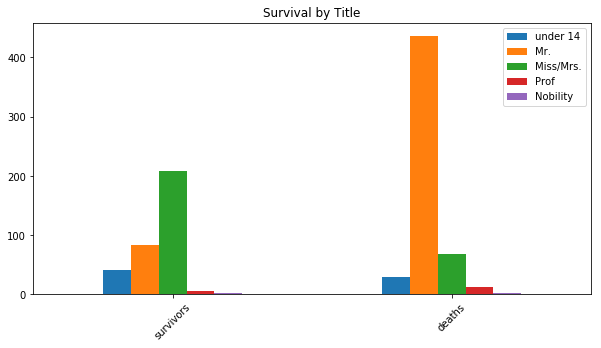

Survivors:
under 14      42
Mr.           83
Miss/Mrs.    209
Prof           5
Nobility       3
Name: Title_group, dtype: int64
Deaths:
under 14      29
Mr.          437
Miss/Mrs.     68
Prof          13
Nobility       2
Name: Title_group, dtype: int64


In [38]:
ax = survival_bar_chart('Title_group', 'Survival by Title', ['under 14', 'Mr.', 'Miss/Mrs.', 'Prof', 'Nobility']);
print("Survivors:")
print(survivors_feature)
print("Deaths:")
print(deaths_feature)

This concludes the EDA of the **Name** variable.

### Age

**Age** is the first continuous numeric variable encountered so it makes sense to investigate it using violin plots and an ECDF.

#### Violin plot function

In [39]:
import random

# Create function to easily standard violin plots with random color
def v_plot(data, title):
    plt.figure(figsize=(10,5))
    random_color = random.choice(['b', 'r', 'g', 'orange', None])
    violin_ax = plt.violinplot(data, showmedians=True, showmeans=True)
    plt.title(title)
    plt.setp(violin_ax['bodies'], facecolor=random_color, edgecolor='k')
    plt.show()

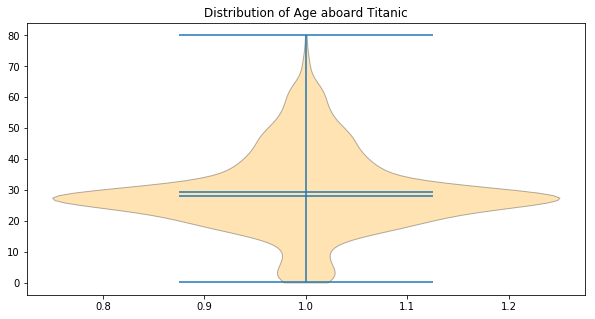

Statistics of Age variable:
count    1309.000000
mean       29.437487
std        12.915275
min         0.170000
25%        22.000000
50%        28.000000
75%        35.000000
95%        55.000000
max        80.000000
Name: Age, dtype: float64


In [40]:
v_plot(df_train_test.Age, "Distribution of Age aboard Titanic")
print("Statistics of Age variable:")
print(df_train_test.Age.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

#### Age ECDF

ECDF function show the distribution in terms of percentage on the vertical axis and quantity on the horizontal axis. A function will need to be created because more than one ECDF will be created for other variables.

#### ECDF Function

In [41]:
import random

# ECDF function
def ecdf(data, column):
    
    # Number of data points
    n = len(data[column])
    
    # x-data for the ECDF: x
    x = np.sort(data[column])
    
    # y-data for the ECDF: y
    y = np.arange(1, n+1)/n
    
    random_color = random.choice(['b', 'r', 'g', 'orange', None])
    
   # plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='.', linestyle='none', color=random_color)
    plt.xlabel("{}".format(column))
    plt.ylabel("ECDF")

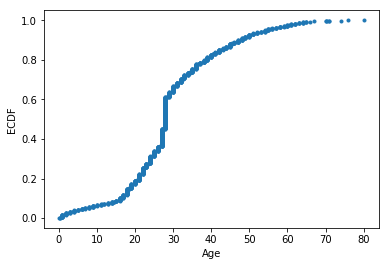

In [42]:
# ECDF of Age
ecdf(df_train_test, 'Age')

The ECDF for the **Age** variable gives an idea of the age distribution among passengers aboard the Titanic:

-  About 20% were under age 20
-  About 40% were between ages 20 and 30
-  About 20% were over age 40
-  80% of the passengers were under age 40

#### What is the breakdown of Age categories among passengers?

To plot the categories of age, bins are created. 

In [43]:
# dict to map age bins to categories
age_dict = {'child':0, 
            'teenager':1, 
            'young adult':2, 
            'adult':3, 
            'elderly':4}

# invert dict
age_dict = dict(zip(age_dict.values(), age_dict.keys()))

# create bins for age categories
for dataset in train_test:
    dataset.loc[dataset.Age < 12, 'Age_bin'] = 0
    dataset.loc[(dataset.Age >= 12) & (dataset.Age < 18), 'Age_bin'] = 1
    dataset.loc[(dataset.Age >= 18) & (dataset.Age < 25), 'Age_bin'] = 2
    dataset.loc[(dataset.Age >= 25) & (dataset.Age < 60), 'Age_bin'] = 3
    dataset.loc[dataset.Age >= 60, 'Age_bin'] = 4
    
    # map dict to Age_bin column: Age_category
    dataset['Age_category'] = dataset.Age_bin.map(age_dict)
    
    dataset.Age_bin = dataset.Age_bin.astype(np.int64)
    
# re-concatenate combined dataframe
df_train_test = pd.concat(train_test, sort=True)

The bins are used to create a bar graph that shows the number of individuals of each age category.

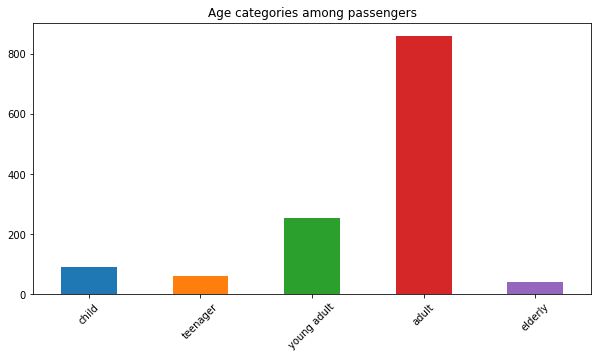

In [44]:
legend = ['child', 'teenager', 'young adult', 'adult', 'elderly']
df_age_categories = df_train_test.Age_bin.value_counts().sort_index()
df_age_categories.index = legend
df_age_categories.plot(kind='bar', figsize=(10,5), title='Age categories among passengers')
plt.xticks(rotation=45)
plt.show()

#### Survival by Age Category

The next part to examine is the survival and deaths within each category. A bar chart is created using the previously defined function.

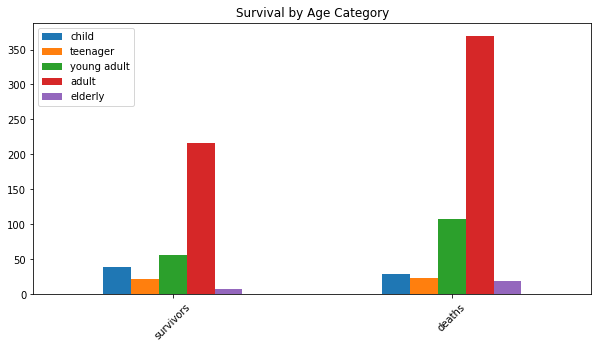

Survial by Age:
child           39
teenager        22
young adult     57
adult          217
elderly          7
Name: Age_bin, dtype: int64
Deaths by Age:
child           29
teenager        23
young adult    108
adult          370
elderly         19
Name: Age_bin, dtype: int64


In [45]:
survival_bar_chart('Age_bin', 'Survival by Age Category', 
                   legend=['child', 'teenager', 'young adult', 'adult', 'elderly'])
print("Survial by Age:")
print(survivors_feature)
print("Deaths by Age:")
print(deaths_feature)

This concludes the EDA of the **Age** variable.

### Sibsp & Parch – Investigating family size

The variables **SibSp** (siblings/spouse) and **Parch** (parents/children) indicate how many relatives each individual had aboard the ship. This may be an important predicting factor of survival if families tried to save each other. 

To expedite the analaysis it makes sense to combine these into a new variable – **Family_size**.

In [46]:
#Combine SibSp & Parch (including individual): Family_size
for dataset in train_test:
    dataset['Family_size'] = dataset.SibSp + dataset.Parch + 1
    df_train_test = pd.concat(train_test, sort=True)
    
df_train_test.head()

,Age,Age_bin,Age_category,Cabin_Deck,Embarked,Family_size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Title_group
0,22.0,2,young adult,U,S,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,3,adult,C,C,2,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,2
2,26.0,3,adult,U,S,1,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,2
3,35.0,3,adult,C,S,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,2
4,35.0,3,adult,U,S,1,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,1


#### Overview of Family_size

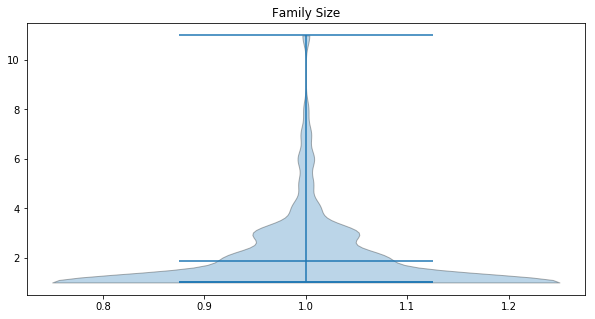

Statistics of Family_size variable:
count    1309.000000
mean        1.883881
std         1.583639
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: Family_size, dtype: float64


In [47]:
v_plot(df_train_test.Family_size, 'Family Size')
print("Statistics of Family_size variable:")
print(df_train_test.Family_size.describe())

#### Family_size ECDF

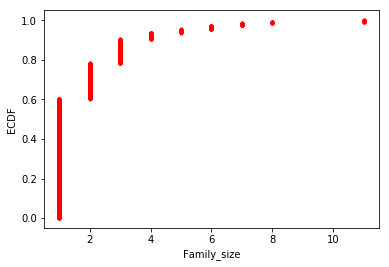

In [48]:
ecdf(df_train_test, 'Family_size')

The ECDF for **Family_size** shows that about 80% of the passengers had a family size of 2 or less.

#### How many couples were aboard?

A couple is denoted where **SibSp** = 1 and **Family_size** = 2; the datapoints are then paired according to the **Ticket** variable, based on the assumption that couples traveled on the same ticket. 

In [49]:
# Select couples based on matching tickets
passenger_pairs = df_train_test[(df_train_test.SibSp == 1) & (df_train_test.Family_size == 2)].sort_values('Ticket')
couples = passenger_pairs['Ticket'].value_counts()
couples = couples[couples == 2]
couples = couples.reset_index()['index'].values
couples = passenger_pairs[passenger_pairs.Ticket.isin(couples)]
couples

,Age,Age_bin,Age_category,Cabin_Deck,Embarked,Family_size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Title_group
236,64.0,4,elderly,D,C,2,75.2500,"Warren, Mr. Frank Manley",0,1128,1,male,1,NaN,110813,Mr,1
366,60.0,4,elderly,D,C,2,75.2500,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",0,367,1,female,1,1.0,110813,Mrs,2
182,18.0,2,young adult,D,S,2,53.1000,"Marvin, Mrs. Daniel Warner (Mary Graham Carmic...",0,1074,1,female,1,NaN,113773,Mrs,2
748,19.0,2,young adult,D,S,2,53.1000,"Marvin, Mr. Daniel Warner",0,749,1,male,1,0.0,113773,Mr,1
151,22.0,2,young adult,C,S,2,66.6000,"Pears, Mrs. Thomas (Edith Wearne)",0,152,1,female,1,1.0,113776,Mrs,2
336,29.0,3,adult,C,S,2,66.6000,"Pears, Mr. Thomas Clinton",0,337,1,male,1,0.0,113776,Mr,1
35,42.0,3,adult,U,S,2,52.0000,"Holverson, Mr. Alexander Oskar",0,36,1,male,1,0.0,113789,Mr,1
383,35.0,3,adult,U,S,2,52.0000,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",0,384,1,female,1,1.0,113789,Mrs,2
137,37.0,3,adult,C,S,2,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,Mr,1
3,35.0,3,adult,C,S,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,2


The dataframe reduces to 146 rows, where each row is an individual who is paired with another. This means that there were 73 couples aboard the ship. 

Additional questions to explore related to families aboard the Titanic: 
-  How many of them survived together?
-  How many wives lost their husbands and vice versa?
-  How many families lost a parent?
-  How many families lost at least one child?

#### Survival and Family_size

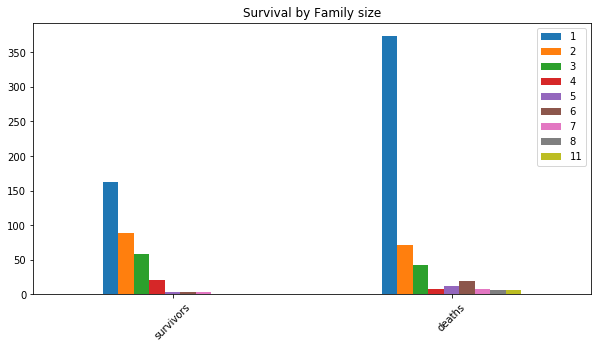

In [50]:
survival_bar_chart('Family_size', 'Survival by Family size')

#### Survival and Family_size Normalized

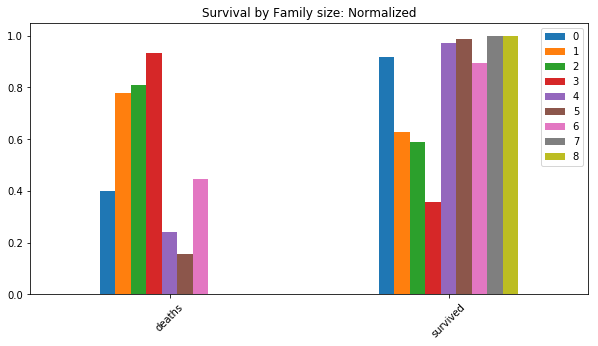

In [51]:
from sklearn import preprocessing

survival_family_size = pd.concat([survivors_feature, deaths_feature], axis=1).fillna(0)

survival_family_size.columns = ['survivors', 'deaths']
survival_family_size.survivors = survival_family_size.survivors.astype(np.int64)

survival_family_size = pd.DataFrame(preprocessing.normalize(survival_family_size)).T

survival_family_size.index = ['deaths', 'survived']

survival_family_size.plot(kind='bar', title='Survival by Family size: Normalized', figsize=(10,5))
plt.xticks(rotation=45)
plt.show()

The normalized graph of survival by family size shows the relative liklihood of survival for members of different size families. 

However, it would be useful to have the counts of each size family aboard.

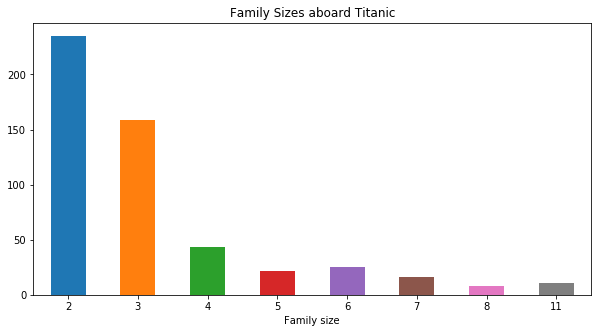

,Family_Size,Num_Individuals,Num_Families_Size,Extra_Individuals
0,2,235,117,1
1,3,159,53,0
2,4,43,10,3
3,5,22,4,2
4,6,25,4,1
5,7,16,2,2
6,8,8,1,0
7,11,11,1,0


In [52]:
df_train_test.Family_size.value_counts()[1:].sort_index().plot(kind='bar', 
                                                           title='Family Sizes aboard Titanic', 
                                                           figsize=(10,5))
plt.xticks(rotation=0)
plt.xlabel('Family size')
plt.show()

family_sizes = df_train_test.Family_size.value_counts()[1:].sort_index().reset_index()

family_sizes.columns = ['Family_Size', 'Num_Individuals']

family_sizes['Num_Families_Size'] = divmod(family_sizes['Num_Individuals'], family_sizes['Family_Size'])[0]

family_sizes['Extra_Individuals'] = divmod(family_sizes['Num_Individuals'], family_sizes['Family_Size'])[1]

family_sizes



What does the above Extra_Individuals column indicate? We can look deeper by examining the names in the two families of size 7, this might give clues:

In [53]:
df_train_test[df_train_test.Family_size == 7].sort_values(by=['Name', 'Age'])

,Age,Age_bin,Age_category,Cabin_Deck,Embarked,Family_size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Title_group
850,4.0,0,child,U,S,7,31.2750,"Andersson, Master. Sigvard Harald Elias",2,851,3,male,4,0.0,347082,Master,0
813,6.0,0,child,U,S,7,31.2750,"Andersson, Miss. Ebba Iris Alfrida",2,814,3,female,4,0.0,347082,Miss,0
119,2.0,0,child,U,S,7,31.2750,"Andersson, Miss. Ellis Anna Maria",2,120,3,female,4,0.0,347082,Miss,0
68,17.0,1,teenager,U,S,7,7.9250,"Andersson, Miss. Erna Alexandra",2,69,3,female,4,1.0,3101281,Miss,2
214,38.0,3,adult,U,S,7,7.7750,"Andersson, Miss. Ida Augusta Margareta",2,1106,3,female,4,NaN,347091,Miss,2
541,9.0,0,child,U,S,7,31.2750,"Andersson, Miss. Ingeborg Constanzia",2,542,3,female,4,0.0,347082,Miss,0
542,11.0,0,child,U,S,7,31.2750,"Andersson, Miss. Sigrid Elisabeth",2,543,3,female,4,0.0,347082,Miss,0
13,39.0,3,adult,U,S,7,31.2750,"Andersson, Mr. Anders Johan",5,14,3,male,1,0.0,347082,Mr,1
610,39.0,3,adult,U,S,7,31.2750,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",5,611,3,female,1,0.0,347082,Mrs,2
379,5.0,0,child,U,S,7,31.3875,"Asplund, Master. Carl Edgar",2,1271,3,male,4,NaN,347077,Master,0


We see two families of size 7: Andersson and Asplund. The Andersson family has 3 adults over age 30, logically there can only be two parents, so we can possibly conclude that the additional adult is an aunt or uncle. In this case the names tell us that Mr. & Mrs. Anders Johan Andersson were present, and the additional adult in their party was Miss. Ida Augusta Margareta Andersson. By her title we can conclude that she was not married, and most likely an aunt (or cousin). It is possible that one (or more) of the children could belong to her, so she could count as a single parent.

The Asplund family has all 7 members accounted for.

### Fare

In [54]:
pd.DataFrame(df_train_test.Fare.describe(percentiles=[0.25, 0.5, 0.75, 0.95])).T.round(2)

,count,mean,std,min,25%,50%,75%,95%,max
Fare,1309.0,33.28,51.74,0.0,7.9,14.45,31.28,133.65,512.33


#### Fare ECDF

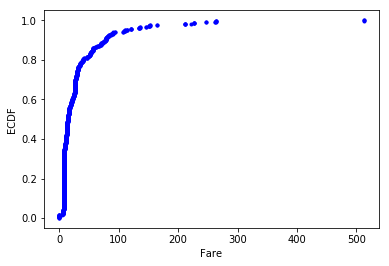

In [55]:
ecdf(train, 'Fare')

The ECDF of **Fare** shows that at least 80% of the passengers paid 50 or less for their ticket. There appears to be an outlier or outliers who paid over $500:

In [56]:
df_train_test[df_train_test.Fare == df_train_test.Fare.max()]

,Age,Age_bin,Age_category,Cabin_Deck,Embarked,Family_size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Title_group
258,35.0,3,adult,U,C,1,512.3292,"Ward, Miss. Anna",0,259,1,female,0,1.0,PC 17755,Miss,2
679,36.0,3,adult,B,C,2,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,680,1,male,0,1.0,PC 17755,Mr,1
737,35.0,3,adult,B,C,1,512.3292,"Lesurer, Mr. Gustave J",0,738,1,male,0,1.0,PC 17755,Mr,1
343,58.0,3,adult,B,C,2,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1235,1,female,0,NaN,PC 17755,Mrs,2


The story behind these 4 passengers is that it was a husband and wife who were traveling with their personal servants.

Source: https://www.encyclopedia-titanica.org/titanic-survivor/thomas-cardeza.html

#### Breakdown of Fare by passenger class (Pclass)

What was the range of Fares paid for by each passenger class? To examine this the **Fare** variable will be grouped by the class variable, **Pclass** and plotted.

In [57]:
df_train_test[['Fare', 'Pclass']].groupby('Pclass').describe(percentiles=[0.25, .5, .75, .95])

Fare                          ...                                  
        count       mean        std    ...          75%        95%       max
Pclass                                 ...                                  
1       323.0  87.508992  80.447178    ...     107.6625  260.88958  512.3292
2       277.0  21.179196  13.607122    ...      26.0000   41.57920   73.5000
3       709.0  13.295480  11.487932    ...      15.2458   34.37500   69.5500

[3 rows x 9 columns]

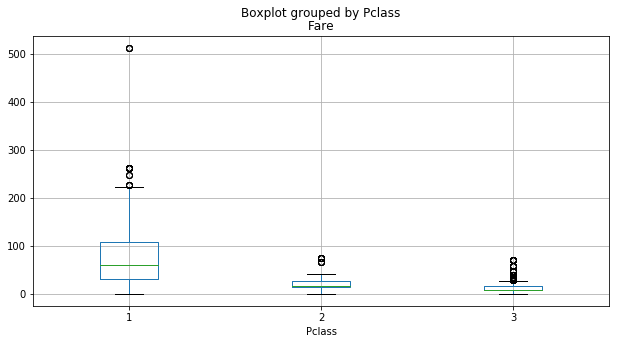

In [58]:
# Create boxplot of Fare for each passenger class (Pclass)
df_train_test.boxplot(column='Fare', by='Pclass', figsize=(10,5))
plt.show()

#### Breakdown of Fare by Point of Departure (Embarked)

How did fare differ depending on the point of departure? This question possibly reveals clues to the socioeconomic conditions of the different cities.

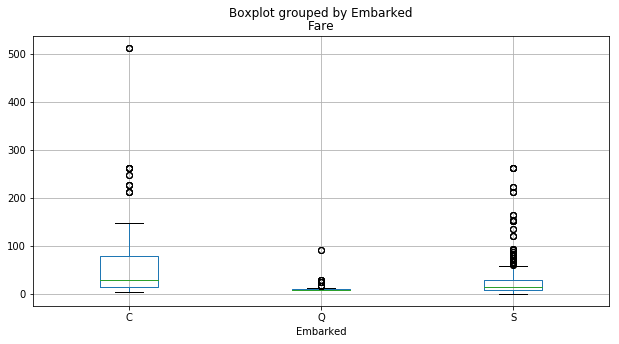

Statistics for Fare by Point of Departure: 


Fare                       ...                                
             count   mean    std   min   ...      50%    75%     95%     max
Cherbourg    270.0  62.34  84.19  4.01   ...    28.52  78.97  238.52  512.33
Queenstown   123.0  12.41  13.62  6.75   ...     7.75  10.20   29.12   90.00
Southampton  916.0  27.51  37.12  0.00   ...    13.00  27.79   82.27  263.00

[3 rows x 9 columns]

In [59]:
# Boxplot of Fare by Embarked
df_train_test.boxplot(column='Fare', by='Embarked', figsize=(10,5))
plt.show()

# Stats describing Fare by Embarked
percentiles=[0.25, 0.5, 0.75, 0.95]
df_fare_embarked_stats = df_train_test[['Fare', 'Embarked']].groupby('Embarked').describe(percentiles=percentiles)
df_fare_embarked_stats.index=["Cherbourg", "Queenstown", "Southampton"]
df_fare_embarked_stats = df_fare_embarked_stats.round(2)
print("Statistics for Fare by Point of Departure: ")
df_fare_embarked_stats




Cherbourg appears to have been a point of departure for more affluent passengers, and Queenstown appears to have been the point of departure for less affluent passengers. Southampton looks like a mixture of both. Here is a map of the route:

In [60]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/5/51/Titanic_voyage_map.png")

#### Fare by Survival

Did paying more for a ticket ensure a greater chance of survival?

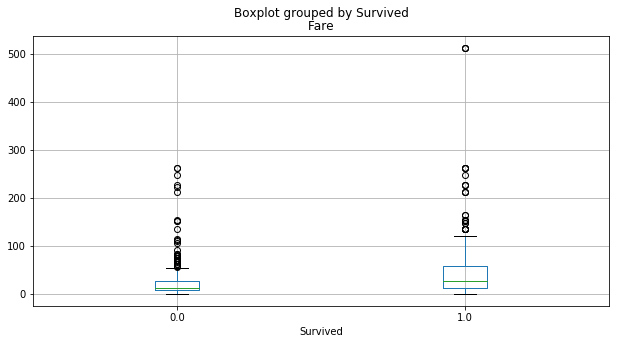

Average Fare of passengers who survived: 48.4
Average Fare of passengers who died: 22.12


In [61]:
df_train_test.boxplot(column='Fare', by='Survived', figsize=(10,5))
plt.show()

print("Average Fare of passengers who survived: {}".format(round(df_train_test[df_train_test.Survived == 1]['Fare'].mean(), 2)))
print("Average Fare of passengers who died: {}".format(round(df_train_test[df_train_test.Survived == 0]['Fare'].mean(), 2)))


It looks like the passengers who survived on average paid more, and passengers who didn't paid less average fare.

### Sex

#### Sex ratio of passengers aboard the Titanic
How many passengers were male and how many were female? This chart will use the combined train and test set

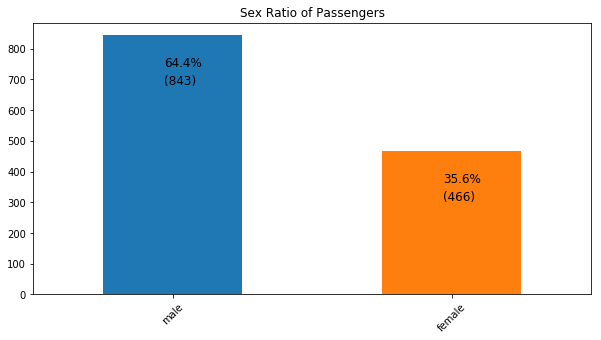

In [62]:
# Create category to represent Sex column as 1 or 0: Sex_group
df_train_test['Sex_group'] = np.where(df_train_test.Sex == 'female', 1, 0)

ax_sex_count = df_train_test.Sex.value_counts().plot(kind='bar', title='Sex Ratio of Passengers', figsize=(10,5))

totals = []

for i in ax_sex_count.patches:
    totals.append(i.get_height())
    
totals = sum(totals)

for patch, idx in zip(ax_sex_count.patches, range(2)):
    
    sex_count = df_train_test.Sex.value_counts()
    sex_percent = round((sex_count[idx]/sex_count.sum())*100,2)
    sex_percent = str(sex_percent)+"%"
    x = (patch.get_x() + patch.get_width()/2)-.03
    y = patch.get_height() - 100
    ax_sex_count.text(x, y, sex_percent, fontsize=12)
    ax_sex_count.text(x, y-60, "({})".format(sex_count[idx]), fontsize=12)
    plt.xticks(rotation=45)

plt.show()

#### What is the survival by sex?

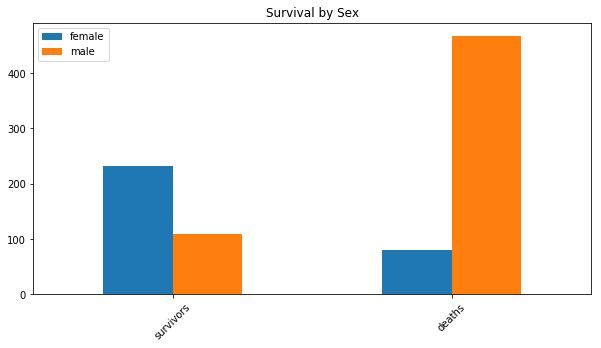

Survivors:
female    233
male      109
Name: Sex, dtype: int64
Deaths:
female     81
male      468
Name: Sex, dtype: int64


In [63]:
survival_bar_chart('Sex', 'Survival by Sex')
print("Survivors:")
print(survivors_feature)
print("Deaths:")
print(deaths_feature)

#### Normalizing data for Survival by Sex

To get a clear picture of the ratios of each survival the data is normalized.

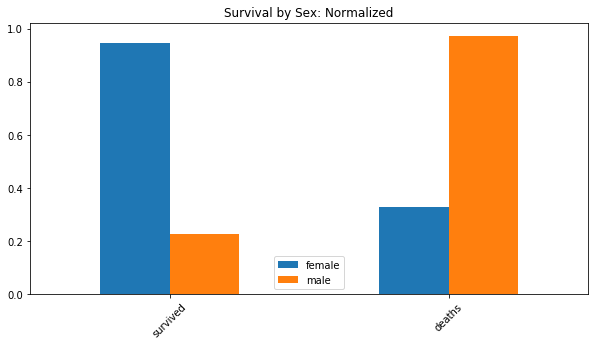

In [64]:
from sklearn import preprocessing

survival_by_sex = pd.concat([survivors_feature, deaths_feature], axis=1)

survival_by_sex = pd.DataFrame(preprocessing.normalize(survival_by_sex))

survival_by_sex.columns = ['survived', 'deaths']
survival_by_sex.index = ['female', 'male']

survival_by_sex.T.plot(kind='bar', title='Survival by Sex: Normalized', figsize=(10,5))
plt.xticks(rotation=45)
plt.show()

The normalized bar chart indicates that males had a lower relative chance of surviving compared to females.

### Embarked

#### Overview of Points of Departure

This graph overview is repeated here.

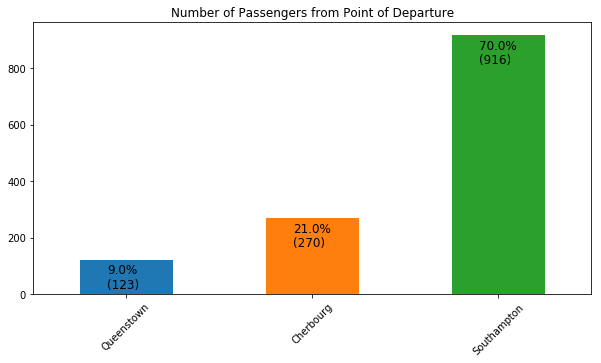

Number of passengers from each point of departure: 
Queenstown     123
Cherbourg      270
Southampton    916
Name: Embarked, dtype: int64


In [65]:
# Construction of bar plot of Embarked
df_embarked = df_train_test.Embarked.value_counts().sort_values()
df_embarked.index = ['Queenstown', 'Cherbourg', 'Southampton']

ax_embarked = df_embarked.plot(kind='bar', figsize=(10,5), title="Number of Passengers from Point of Departure")
plt.xticks(rotation=45)

# Annotating the axes with the percentage and number of passengers in each category
totals = []

for i in ax_embarked.patches:
    totals.append(i.get_height())

total_rect = sum(totals)

for i, idx in zip(ax_embarked.patches, range(3)):
    perc = round(i.get_height()/total_rect,2)*100
    perc_str = str(perc)+"%"
    x = i.get_x()+((i.get_width()/2)-0.1)
    y = i.get_height()-50
    ax_embarked.text(x, y, s=perc_str, fontsize=12)
    ax_embarked.text(x, y-50, "({})".format(df_embarked.values[idx]), fontsize=12)
    
# show plot
plt.show()
print("Number of passengers from each point of departure: ")
print(df_embarked)

#### Embarked & Survival

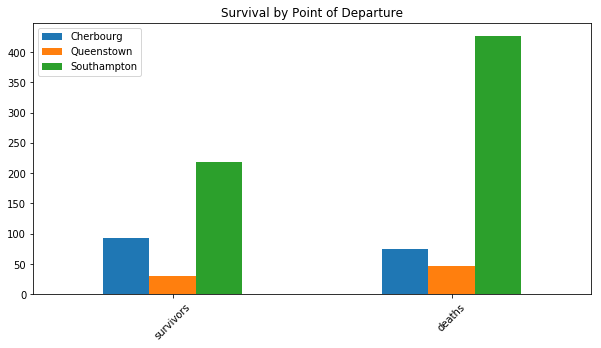

In [66]:
survival_bar_chart('Embarked', "Survival by Point of Departure", ['Cherbourg', 'Queenstown', 'Southampton'])

The next step is to normalize the data to compare relative ratios among groups.

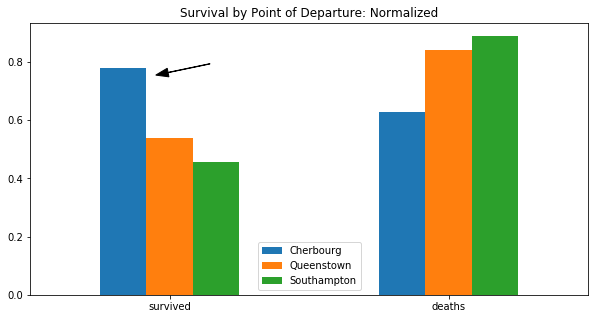

In [67]:
df_embarked_survival = pd.concat([survivors_feature, deaths_feature], axis=1)

df_embarked_survival = pd.DataFrame(preprocessing.normalize(df_embarked_survival))

df_embarked_survival.columns = ['survived', 'deaths']
df_embarked_survival.index = ['Cherbourg', 'Queenstown', 'Southampton']

ax_embarked_survival = df_embarked_survival.T.plot(kind='bar', title='Survival by Point of Departure: Normalized', figsize=(10,5))
x = ax_embarked_survival.patches[0].get_x() + ax_embarked_survival.patches[0].get_width() + 0.25
y = ax_embarked_survival.patches[0].get_height()+0.02

ax_embarked_survival.arrow(x, y, -.15, -0.03, head_width=0.03, head_starts_at_zero=True, color='k')

plt.xticks(rotation=0)
plt.show()

Examining this graph shows an anomaly: Cherbourg is the only point of departure where more passengers survived than died. This is visible in the non-normalized chart, but barely. 

Questions:
-  How significant is the difference? (p-value)
-  Why is this?

More analysis is necessary to answer this question, but it is possible to come up with a hypothesis. In this case, perhaps this has something to do with the passenger class composition being different for Cherbourg than for the other points of departure.

#### Embarked & Pclass: What is the relationship between passenger class and point of departure?

Did the point of departure determine the class of the passengers?

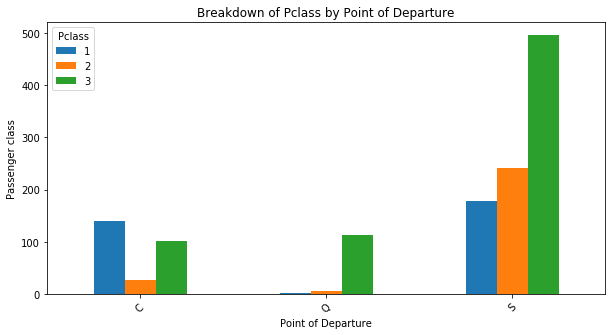

In [68]:
df_embarked_class = df_train_test[(df_train_test.Embarked == "Q") |
             (df_train_test.Embarked == "S") |
             (df_train_test.Embarked == "C")][['Embarked', 'Pclass']]
embarked_pclass = df_embarked_class.groupby('Embarked').Pclass.value_counts()
embarked_pclass.unstack().plot(kind='bar', title='Breakdown of Pclass by Point of Departure',
                              figsize=(10,5))
plt.xticks(rotation=45)
plt.xlabel('Point of Departure')
plt.ylabel('Passenger class')
plt.show()

Normalising the data:

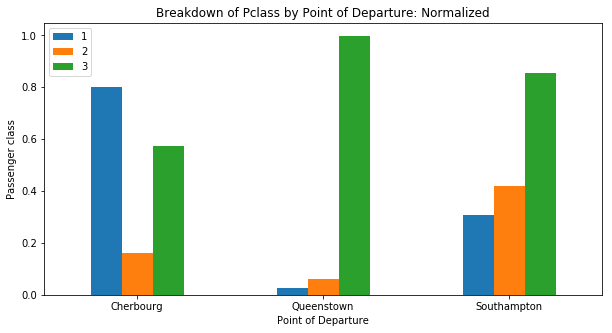

In [69]:
embarked_pclass_norm = pd.DataFrame(preprocessing.normalize(embarked_pclass.unstack()))
embarked_pclass.unstack() 

embarked_pclass_norm.index = ['Cherbourg', 'Queenstown', 'Southampton']
embarked_pclass_norm.columns = ['1', '2', '3']
embarked_pclass_norm.plot(kind='bar', title='Breakdown of Pclass by Point of Departure: Normalized',
                         figsize=(10,5))
plt.xticks(rotation=0)
plt.xlabel('Point of Departure')
plt.ylabel('Passenger class')
plt.show()

This plot shows that Cherbourg (France) had a very high number of First Class passengers, which probably relates to the fact that more survivors came from Cherbourg than any other town, as noticed in the graph breakdown of Embarked and Pclass.

## 6. Modelling with XGBoost

Overview of dataframe

In [70]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Deck,Title,Title_group,Age_bin,Age_category,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U,Mr,1,2,young adult,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2,3,adult,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,U,Miss,2,3,adult,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,Mrs,2,3,adult,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U,Mr,1,3,adult,1


In [71]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Deck,Title,Title_group,Age_bin,Age_category,Family_size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,U,Mr,1,3,adult,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,U,Mrs,2,3,adult,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,U,Mr,1,4,elderly,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,U,Mr,1,3,adult,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,U,Mrs,2,2,young adult,3


These features will be removed from dataset because they don't contain useful information:
* Name
* Ticket
* Age_category

In [72]:
features_drop = ['Name', 'Ticket', 'Age_category', 'PassengerId']

for dataset in train_test:
    dataset.drop(features_drop, axis=1, inplace=True)
    
df_train_test = pd.concat(train_test, sort=True)
df_train_test.head()

,Age,Age_bin,Cabin_Deck,Embarked,Family_size,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,Title_group
0,22.0,2,U,S,2,7.2500,0,3,male,1,0.0,Mr,1
1,38.0,3,C,C,2,71.2833,0,1,female,1,1.0,Mrs,2
2,26.0,3,U,S,1,7.9250,0,3,female,0,1.0,Miss,2
3,35.0,3,C,S,2,53.1000,0,1,female,1,1.0,Mrs,2
4,35.0,3,U,S,1,8.0500,0,3,male,0,0.0,Mr,1


In [73]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Deck,Title,Title_group,Age_bin,Family_size
0,0,3,male,22.0,1,0,7.2500,S,U,Mr,1,2,2
1,1,1,female,38.0,1,0,71.2833,C,C,Mrs,2,3,2
2,1,3,female,26.0,0,0,7.9250,S,U,Miss,2,3,1
3,1,1,female,35.0,1,0,53.1000,S,C,Mrs,2,3,2
4,0,3,male,35.0,0,0,8.0500,S,U,Mr,1,3,1


**Select Features & Labels**

In [93]:
# Select features
X = train.drop('Survived', axis=1)

# Select labels
y = train['Survived'].values

In [97]:
X.shape, test.shape

((891, 12), (418, 12))

**Vectorizing Objects**

Features must be numeric. In order to vectorize non-numeric features the data must be combined, vectorized, and then separated, or the model will not work for predictions.

In [102]:
df_X_test = pd.concat([X, test], sort=True)

df_X_test.shape

(1309, 12)

Vectorize:

In [103]:
from sklearn.feature_extraction  import DictVectorizer

df_X_test_dict = df_X_test.to_dict('records')

dv = DictVectorizer(sparse=False)

df_X_test_encoded = dv.fit_transform(df_X_test_dict)

# Print the resulting first five rows
print(df_X_test_encoded[:5,:])

# Print the vocabulary
print(dv.vocabulary_)

[[22.      2.      0.      0.      0.      0.      0.      0.      0.
   0.      1.      0.      0.      1.      2.      7.25    0.      3.
   0.      1.      1.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      1.      0.
   0.      0.      0.      1.    ]
 [38.      3.      0.      0.      1.      0.      0.      0.      0.
   0.      0.      1.      0.      0.      2.     71.2833  0.      1.
   1.      0.      1.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      2.    ]
 [26.      3.      0.      0.      0.      0.      0.      0.      0.
   0.      1.      0.      0.      1.      1.      7.925   0.      3.
   1.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      1.      0.      0.      0.      0.
   0.      0.      0.      2.    ]
 [35.      3.      0.      0.      1.      0.      0.  

Separate training (X) and test data

In [112]:
X_encoded = df_X_test_encoded[:891,:]

test_encoded = df_X_test_encoded[891:,:]

print(X_encoded.shape, test_encoded.shape)


(891, 40) (418, 40)


**Build Model**

In [113]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)

accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.860335


The initial accuracy of the first run is 86%.

**Making the Prediction**

In [137]:
titanic = xg_cl.predict(test_encoded)

Does the prediction look right?

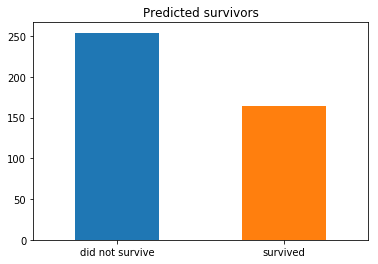

In [154]:
# visualize predicted survivors
df_titanic = pd.DataFrame({"Survived":titanic})
test_survivors = df_titanic['Survived'].value_counts()
test_survivors.index = ["did not survive", "survived"]
test_survivors.plot(kind='bar', title="Predicted survivors")
plt.xticks(rotation=0)
plt.show()

Looks about right.

**Preparing the submission**

In [160]:
# retrieve passenger IDs
test_Id = pd.read_csv('../input/test.csv')

# assemble IDs and predictions 
submission = pd.DataFrame({"PassengerId":test_Id['PassengerId'], "Survived":titanic})

# write out
submission.to_csv("submission.csv", index=False)

submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Checking the submission

In [161]:
submission = pd.read_csv("submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
